### **Random forest**

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import pickle
from pickle import dump
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import os
from utils import get_classifier_metrics

In [78]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from pickle import dump
import warnings

warnings.filterwarnings('ignore')

In [79]:
df = pd.read_csv('/workspaces/GuilloMansa-MachineLearning/data/raw/diabetes.csv')

In [80]:
# Dividimos el conjunto de datos en muestras de train y test
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Instancia de: from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)

In [81]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [82]:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

### **Modelado y entreno**

In [83]:
xgb = XGBClassifier(n_estimators=200,
                    learning_rate=0.1,
                    random_state=18,
                    use_label_encoder=False,
                    eval_metric='mlogloss')
ada = AdaBoostClassifier(n_estimators=200,
                         learning_rate=0.1,
                         random_state=18)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [85]:
xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [86]:
ada.fit(X_train, y_train)

,estimator,None
,n_estimators,200
,learning_rate,0.1
,algorithm,'deprecated'
,random_state,18


In [87]:
# predicción
ada_y_pred_test = ada.predict(X_test)
xgb_y_pred_test = xgb.predict(X_test)


ada_y_pred_train = ada.predict(X_train)
xgb_y_pred_train = xgb.predict(X_train)

In [88]:
accuracy_train = (accuracy_score(y_train, ada_y_pred_train),
                  accuracy_score(y_train, xgb_y_pred_train))
accuracy_test = (accuracy_score(y_test, ada_y_pred_test),
                 accuracy_score(y_test, xgb_y_pred_test))

accuracy = pd.DataFrame(data=[accuracy_train, accuracy_test],
                        columns=['AdaBoost', 'XGBoost'],
                        index=['Train set', 'Test set'])

accuracy

,AdaBoost,XGBoost
Train set,0.788274,1.000000
Test set,0.740260,0.714286


Primeras observaciones:

En el train set XGBoost alcanza 100% de accuracy, lo cual no es bueno, seguramente esté sobreajustando. Al ser un data set pequeño. Y como nos da 0.71 en test, puede confirmar que está tomando como es, o que memoriza bien pero no generaliza hacia una buena prediccion.

En cambio ada generaliza mejor, tiene menor accuracy en entrenamiento pero rinde mejor en test, tiene mas equilibrio.

Vamos a usar la hiperparametrizacion en xgboost para regularlo e intentar mejorar el resultado y aplacar el overfiting.

### **Hiperparametrizacion**

In [101]:
# Definir hiperparámetros a probar
xgb_y_pred_test = {'n_estimators':[20, 30, 40],
                   'max_depth': [1, 2, 5],
                   'gamma':[0.5, 0.75, 1, 2, 5],
                   'min_child_weight': [1, 2, 3],
                   'max_delta_step': [1, 2, 4],
                   'subsample':[0.1, 0.2, 0.5, 0.75]}

# Implementar GridSearchCV
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=18),
                                xgb_y_pred_test,
                                cv=5,
                                n_jobs=-1,
                                verbose=1)

# Entrenamos
grid_search_xgb.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
grid_search_xgb.best_params_

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


{'gamma': 1,
 'max_delta_step': 2,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 30,
 'subsample': 0.5}

In [102]:
# Mejor modelo
grid_search_xgb.best_estimator_

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [103]:

# Entrenamos
grid_search_xgb.best_estimator_.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [104]:
y_pred_test_grid = grid_search_xgb.best_estimator_.predict(X_test)
y_pred_train_grid = grid_search_xgb.best_estimator_.predict(X_train)

In [105]:
# Métricas del Boosting de Algoritmos.

get_classifier_metrics(y_pred_test_grid, y_test, y_pred_train_grid, y_train)

,Accuracy,F1 Score,Precision,Recall
Train set,0.837134,0.837134,0.837134,0.837134
Test set,0.733766,0.733766,0.733766,0.733766


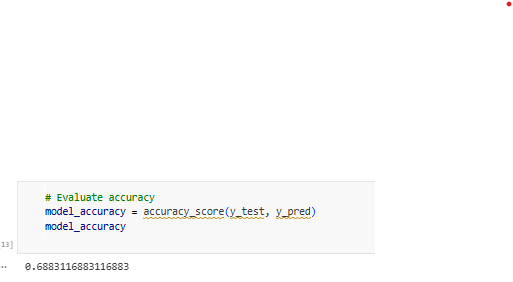

#### **Observaciones generales** 

- Vemos que el overfitting se reduco considerablemente con el gridsearch, paso del 1 al 0.83 y de 0.83 a 0.73. Mas equilibrado.
- El modelo generaliza mejor, pero aún hay margen de mejora. La diferencia entre train y test es menor al 0.10. 
- La accuracy en test sigue siendo no tan buena, lo cual puede tener mejoras.

- En lineas generales, el modelo es bsatante consistente y la prediccion es buena.